In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.096067  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000  


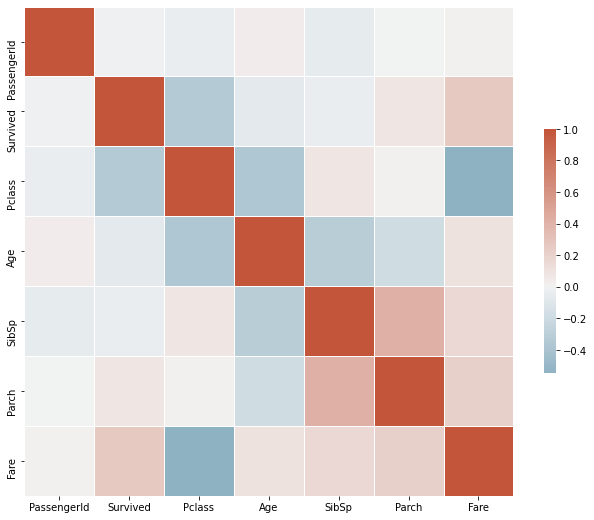

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
# plt.matshow(train.corr())
# cb = plt.colorbar()
# cb.ax.tick_params()
# plt.show()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(train.corr(),  cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print(train.corr())

# **Visualisation part**
In this block, we are importing the .csv files and converting them to dataframes in order to be able to print and visualize the correlation matrix.
From the output, we can see that the features with highest correlation with 'Survived' are Fare, Pclass, Parch and Age. 


In [3]:
featureswithTarget = ["Pclass", "Sex", "Age", "Fare","Survived"]
temp = train[featureswithTarget]
mean_value = temp['Age'].mean()
temp['Age'] = temp['Age'].fillna(mean_value)
mean_value = temp['Fare'].mean()
temp['Fare'] = temp['Fare'].fillna(mean_value)

temp["Sex"].replace('female', 0, inplace=True)
temp["Sex"].replace('male', 1, inplace=True)

# **PREPROCESSING**
Here we use only the best features that were decided from the correlation, with adding the 'Sex' feature as it is binary and wasn't in the correlation.
Also, we must fill the null values in 'Age' and 'Fare' features as Logistic regression doesn't work with null values. The technique used here is filling with the mean of the feature.

Moreover, we have to turn 'male' and 'female' values in the 'Sex' feature to numeric values as 0 and 1 to work.

**Note:** 'Parch' feature is removed as it gives less score although having high correlation relative to other features.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(temp, temp["Sex"]):
    strat_train_set = temp.loc[train_index]
    strat_test_set = temp.loc[test_index]

# **Split the Data to Train and Validation**
Here we split the data using stratified shuffle split instead of normal train_test_split in order to split the data with maintaining the percentages of males and females in the original whole data set, so that the 80% of train data will have the same original percentage of males and females instead of random selection, and the same goes for the validation data.


In [5]:
features = ["Pclass", "Sex", "Age", "Fare"]  
X_train = strat_train_set[features]
y_train = strat_train_set["Survived"]
X_val = strat_test_set[features]
y_val = strat_test_set["Survived"]



# **Prepearing model inputs**
Here we use the output of stratified shuffled split which are the train data and test data to produce the model input which are:
* X-train: Containing the features' values needed to train the model
* y-train: Containing the output of Survived corresponding to features in X-train
* X-val:   Containing the features' values needed to test the model
* y-val:   Containing the output of Survived corresponding to features in X-val

In [6]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression()

# **Model Building**
Here we import and train the Logistic regression model with the train data features and output.

In [7]:
# predictions = logisticRegr.predict(X_val)
score = logisticRegr.score(X_val, y_val)
print(score)

0.7932960893854749


# **Predicition and Model Evaluation**
Here we predict if passengers  will survive or not using validation data. 
The model is evaluated using the score function which predicts using the X_val and compares the output to the real count of survived people
then it outputs the score which is the right predictions count / all predictions count. Thus, it is the percentage of accuracy

# **Submission**
Last block is where we apply the preprocessing to the test data and use it to predict the survival list to be submitted, but we have to turn it to dataframe then to .csv file first with the needed columns.

In [8]:
test = test_data[features]
mean_value = test['Age'].mean()
test['Age'] = test['Age'].fillna(mean_value)
mean_value = test['Fare'].mean()
test['Fare'] = test['Fare'].fillna(mean_value)

test["Sex"].replace('female', 0, inplace=True)
test["Sex"].replace('male', 1, inplace=True)
test_preds = logisticRegr.predict(test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': test_preds})
print(output)
output.to_csv('submission.csv', index=False)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
